# **Major Steps**


- Download dataset
- use the dataset to train the model
- download best model
- create Flask app
  - Frontend <-> Backend <-> Model

In [ ]:
# Download dataset from kaggle

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content
!unzip /content/chest-xray-pneumonia.zip -d /content/chest-xray-pneumonia

Streaming output truncated to the last 5000 lines.
  inflating: /content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: /content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: /content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: /content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: /content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: /content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: /content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: /content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: /content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: /content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: /content/chest-xray-pneumonia/chest_xray/

In [ ]:
import os, shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import skimage
import skimage.segmentation

%matplotlib inline
plt.style.use('ggplot')

In [ ]:
labels=['PNEUMONIA', 'NORMAL']

img_size=128

def get_data(data_dir):
    data=[]
    for label in labels:
        path=os.path.join(data_dir, label)
        class_num=labels.index(label)   # index=0 - PNEUMONIA & index=1- NORMAL

        for img in os.listdir(path):
          try:
            img_arr=cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
            if img_arr is None:
              continue  #Skip img if there is any issue

            resized_arr=cv2.resize(img_arr, (img_size,img_size))
            data.append([resized_arr, class_num])   #data=[[.......], 0/1], [[....], 0/1]

          except Exception as e:
            print(f"Error in processing {img}:{e}")
    return data

In [ ]:
train=get_data("/content/chest-xray-pneumonia/chest_xray/train")
test=get_data("/content/chest-xray-pneumonia/chest_xray/test")
val=get_data("/content/chest-xray-pneumonia/chest_xray/val")

In [ ]:
train[1]

[array([[163, 163, 158, ...,  71,  70,  66],
        [165, 170, 158, ...,  76,  73,  69],
        [176, 173, 163, ...,  72,  69,  71],
        ...,
        [ 27,  33,  30, ...,  31,  29,  24],
        [ 25,  34,  27, ...,  30,  27,  21],
        [ 31,  32,  25, ...,  34,  27,  25]], dtype=uint8),
 0]

In [ ]:
pneumonia=os.listdir("/content/chest-xray-pneumonia/chest_xray/train/PNEUMONIA")
pneumonia_dir="/content/chest-xray-pneumonia/chest_xray/train/PNEUMONIA"

pneumonia

['person333_bacteria_1540.jpeg',
 'person337_bacteria_1561.jpeg',
 'person302_bacteria_1430.jpeg',
 'person641_virus_1222.jpeg',
 'person1911_bacteria_4815.jpeg',
 'person1293_virus_2219.jpeg',
 'person1187_bacteria_3136.jpeg',
 'person669_bacteria_2562.jpeg',
 'person1618_bacteria_4258.jpeg',
 'person423_virus_869.jpeg',
 'person774_bacteria_2678.jpeg',
 'person515_bacteria_2187.jpeg',
 'person1149_virus_1924.jpeg',
 'person399_virus_793.jpeg',
 'person7_bacteria_28.jpeg',
 'person868_virus_1513.jpeg',
 'person985_bacteria_2912.jpeg',
 'person475_bacteria_2024.jpeg',
 'person955_bacteria_2880.jpeg',
 'person701_bacteria_2600.jpeg',
 'person445_virus_916.jpeg',
 'person772_virus_1401.jpeg',
 'person458_virus_945.jpeg',
 'person734_virus_1355.jpeg',
 'person30_bacteria_147.jpeg',
 'person146_virus_296.jpeg',
 'person98_virus_182.jpeg',
 'person44_bacteria_219.jpeg',
 'person952_virus_1623.jpeg',
 'person933_virus_1594.jpeg',
 'person1341_virus_2313.jpeg',
 'person920_virus_1577.jpeg',
 

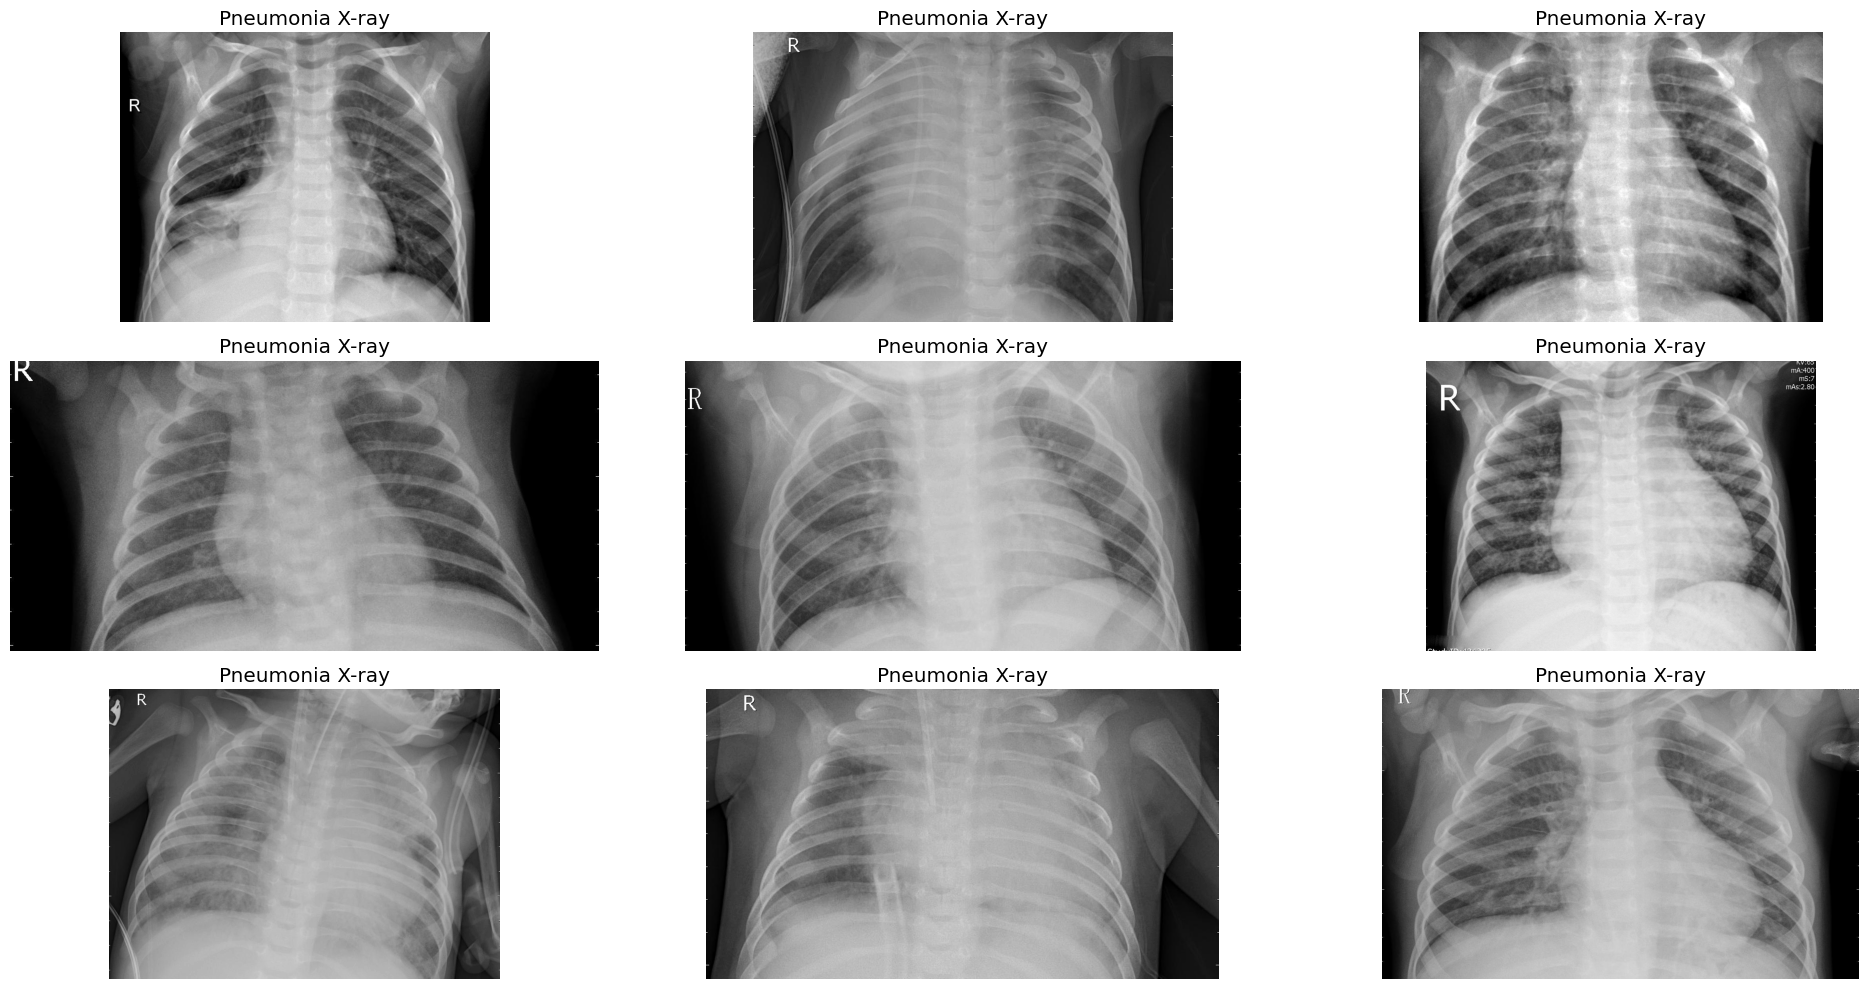

In [ ]:
plt.figure(figsize=(20,10))

for i in range(9):
  plt.subplot(3,3,i+1)
  img=plt.imread(os.path.join(pneumonia_dir,pneumonia[i]))
  plt.imshow(img, cmap='gray')
  plt.axis("off")
  plt.title("Pneumonia X-ray")
plt.tight_layout()

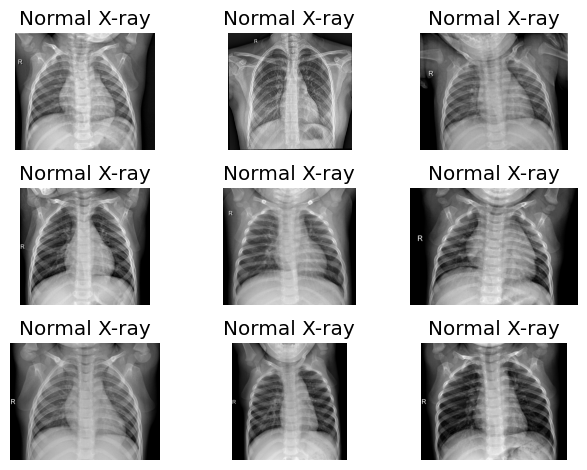

In [ ]:
# Visualizing normal x ray

normal=os.listdir("/content/chest-xray-pneumonia/chest_xray/train/NORMAL")
normal_dir="/content/chest-xray-pneumonia/chest_xray/train/NORMAL"

for i in range(9):
  plt.subplot(3,3,i+1)
  img=plt.imread(os.path.join(normal_dir,normal[i]))
  plt.imshow(img, cmap='gray')
  plt.axis("off")
  plt.title("Normal X-ray")
plt.tight_layout()

<Axes: xlabel='count'>

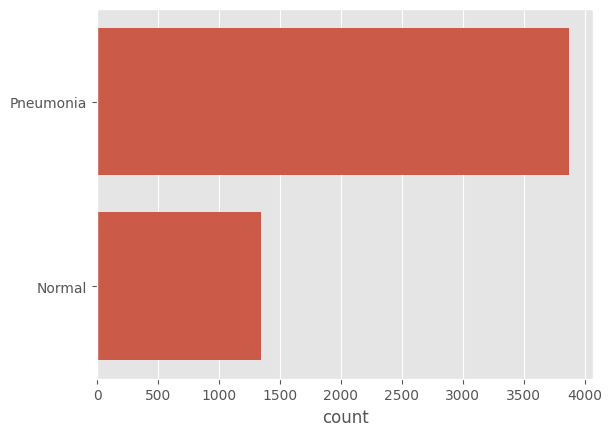

In [ ]:
listx=[]
for i in train:
  if (i[1]==0):
    listx.append("Pneumonia")
  else:
    listx.append("Normal")

sns.countplot(listx)

In [ ]:
# Data augmentation and Resizing

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
train_datagen=ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=0.4,
    vertical_flip=0.4,
    rotation_range=40,
    shear_range=0.2,
    width_shift_range=0.4,
    height_shift_range=0.4,
    fill_mode='nearest'
)

valid_datagen=ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255)



In [ ]:
train_generator=train_datagen.flow_from_directory("/content/chest-xray-pneumonia/chest_xray/train",
                                                  batch_size=32,
                                                  target_size=(128,128),
                                                  class_mode="categorical",
                                                  shuffle=True,
                                                  seed=42,
                                                  color_mode='rgb')

valid_generator=valid_datagen.flow_from_directory("/content/chest-xray-pneumonia/chest_xray/val",
                                              batch_size=32,
                                              target_size=(128,128),
                                              class_mode="categorical",
                                              shuffle=True,
                                              seed=42,
                                              color_mode='rgb')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [ ]:
class_labels=train_generator.class_indices

class_labels

{'NORMAL': 0, 'PNEUMONIA': 1}

In [ ]:
# Flipping key and value

class_name={value:key for (key,value) in class_labels.items()}

class_name

{0: 'NORMAL', 1: 'PNEUMONIA'}

In [ ]:
# VGG19 CNN Architecture

base_model=VGG19(input_shape=(128,128,3),
                 include_top=False,
                 weights='imagenet')

for layer in base_model.layers:
  layer.trainable=False

x=base_model.output
flat=Flatten()(x)
class1=Dense(4608, activation='relu')(flat)
dropout=Dropout(0.2)(class1)
class2=Dense(1152, activation='relu')(dropout)
output=Dense(2,activation='softmax')(class2)

model_01=Model(base_model.inputs, output)

model_01.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 63,089,602 (240.67 MB)

 Trainable params: 43,065,218 (164.28 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
filepath="model.keras"

es=EarlyStopping(monitor='val_loss', verbose=1, mode="min", patience=4)

cp=ModelCheckpoint(filepath, monitor="val_loss", save_best_only=True, save_weights_only=False, mode="auto", save_freq="epoch")

lrr=ReduceLROnPlateau(monitor="val_accuracy", patience=3, verbose=1, factor=0.5, mil_lr=0.0001)

sgd=SGD(learning_rate=0.001, decay=1e-6, momentum=0.1, nesterov=True)

model_01.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [ ]:
history_01=model_01.fit(train_generator,
                        steps_per_epoch=50,
                        epochs=4,
                        callbacks=[es, cp,lrr],
                        validation_data=valid_generator
                        )

Epoch 1/4
50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 575ms/step - accuracy: 0.7662 - loss: 0.4803 - val_accuracy: 0.5000 - val_loss: 0.7304 - learning_rate: 0.0010
Epoch 2/4
50/50 ━━━━━━━━━━━━━━━━━━━━ 29s 580ms/step - accuracy: 0.7790 - loss: 0.4557 - val_accuracy: 0.5625 - val_loss: 0.6129 - learning_rate: 0.0010
Epoch 3/4
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 470ms/step - accuracy: 0.7870 - loss: 0.4411 - val_accuracy: 0.7500 - val_loss: 0.5155 - learning_rate: 0.0010
Epoch 4/4
13/50 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.8389 - loss: 0.3897

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.8229 - loss: 0.3949 - val_accuracy: 0.8125 - val_loss: 0.4874 - learning_rate: 0.0010


In [ ]:
# Saving model weights

if not os.path.isdir("model_weights/"):
  os.mkdir("model_weights/")

model_01.save(filepath="model_weights/vgg19_model_01.h5", overwrite=True)

In [ ]:
test_generator=test_datagen.flow_from_directory("/content/chest-xray-pneumonia/chest_xray/test",
                                              batch_size=32,
                                              target_size=(128,128),
                                              class_mode="categorical",
                                              shuffle=True,
                                              seed=42,
                                              color_mode='rgb')

Found 624 images belonging to 2 classes.


In [ ]:
model_01.load_weights("model_weights/vgg19_model_01.h5")

vgg_val_eval_01=model_01.evaluate(valid_generator)
vgg_test_eval_01=model_01.evaluate(test_generator)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.8125 - loss: 0.4874


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step - accuracy: 0.7919 - loss: 0.4848


In [ ]:
print(f"Validation_loss: {vgg_val_eval_01[0]}")
print(f"Validation_accuracy: {vgg_val_eval_01[1]}")
print(f"Test_loss: {vgg_test_eval_01[0]}")
print(f"Test accuracy: {vgg_test_eval_01[1]}")

Validation_loss: 0.4874010980129242
Validation_accuracy: 0.8125
Test_loss: 0.4785211980342865
Test accuracy: 0.7916666865348816
